In [1]:
import numpy as np

from keras.preprocessing import sequence
import keras.models as km
import keras.layers as kl
import keras.constraints as kc
from keras.datasets import imdb
from keras import losses

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as ipw

import data_preparation as mdp
from mercari_config import MercariConfig

Using TensorFlow backend.


In [2]:
num_words = MercariConfig.MAX_WORDS_FROM_INDEX + MercariConfig.INDICATOR_WORDS_COUNT
max_seq_len = MercariConfig.MAX_WORDS_ITEM_DESC + 1 # Remember: first word is always <START>
embedding_dims = 32
batch_size = 200

AttributeError: type object 'MercariConfig' has no attribute 'MAX_WORDS_FROM_INDEX'

In [3]:
%%time

train_data = mdp.load_data(MercariConfig.TRAINING_SET_PREP_W2I_FILE)
X_seq_train = train_data.drop(columns=['name', 'item_condition_id', 'category_name', 'brand_name', 'price', 
                                       'shipping', 'item_description', 'category_id', 'brand_id']).as_matrix()
x_cat_train = train_data['category_id'].as_matrix()
x_brand_train = train_data['brand_id'].as_matrix()
x_f_train = train_data[['item_condition_id', 'shipping']].as_matrix()
y_train = train_data['price'].as_matrix()

CPU times: user 4.03 s, sys: 444 ms, total: 4.47 s
Wall time: 4.47 s


In [4]:
print(X_seq_train.shape, x_cat_train.shape, x_brand_train.shape, x_f_train.shape, y_train.shape)

(148253, 301) (148253,) (148253,) (148253, 2) (148253,)


In [5]:
%%time

X_seq_train = sequence.pad_sequences(X_seq_train, maxlen=max_seq_len, padding='post', truncating='post')

CPU times: user 948 ms, sys: 128 ms, total: 1.08 s
Wall time: 1.07 s


In [7]:
feature_input = kl.Input(shape=(2,), name='feature_input')
category_input = kl.Input(shape=(1,), name='category_input')
brand_input = kl.Input(shape=(1,), name='brand_input')
item_desc_input = kl.Input(shape=(max_seq_len,), name='item_desc_input')

item_desc_embedding = kl.Embedding(num_words, embedding_dims, name='item_desc_embedding')
#item_desc_embedding_dropout = kl.SpatialDropout1D(0.5, name='item_desc_embedding_dropout')
item_desc_lstm_1 = kl.CuDNNLSTM(units=200, name='item_desc_lstm_1') #, return_sequences=True)
#item_desc_lstm_dropout = kl.Dropout(0.5, name='item_desc_lstm_dropout')
#item_desc_lstm_2 = kl.CuDNNLSTM(units=200, name='item_desc_lstm_2')
#item_desc_stacked_lstm = kl.StackedRNNCells(cells=[item_desc_lstm_1, item_desc_lstm_2], name='item_desc_stacked_lstm')


category_embedding = kl.Embedding(1038, 10, name='category_embedding')
category_reshape = kl.Reshape(target_shape=(10,), name='category_reshape')

brand_embedding = kl.Embedding(2372, 10, name='brand_embedding')
brand_reshape = kl.Reshape(target_shape=(10,), name='brand_reshape')

input_fusion = kl.Concatenate(axis=1, name='input_fusion')
fusion_dense_1 = kl.Dense(300, activation='relu', name='fusion_dense_1')
fusion_dense_2 = kl.Dense(200, activation='relu', name='fusion_dense_2')
fusion_dense_3 = kl.Dense(1, activation='relu', name='fusion_dense_3')

item_desc_output = item_desc_embedding(item_desc_input)
#item_desc_output = item_desc_embedding_dropout(item_desc_output)
item_desc_output = item_desc_lstm_1(item_desc_output)
#item_desc_output = item_desc_lstm_dropout(item_desc_output)
#item_desc_output = item_desc_lstm_2(item_desc_output)

category_output = category_embedding(category_input)
category_output = category_reshape(category_output)

brand_output = brand_embedding(brand_input)
brand_output = brand_reshape(brand_output)

output = input_fusion([item_desc_output, category_output, brand_output, feature_input])
output = fusion_dense_1(output)
output = fusion_dense_2(output)
prediction = fusion_dense_3(output)

model = km.Model(inputs=[feature_input, category_input, brand_input, item_desc_input], outputs=prediction)

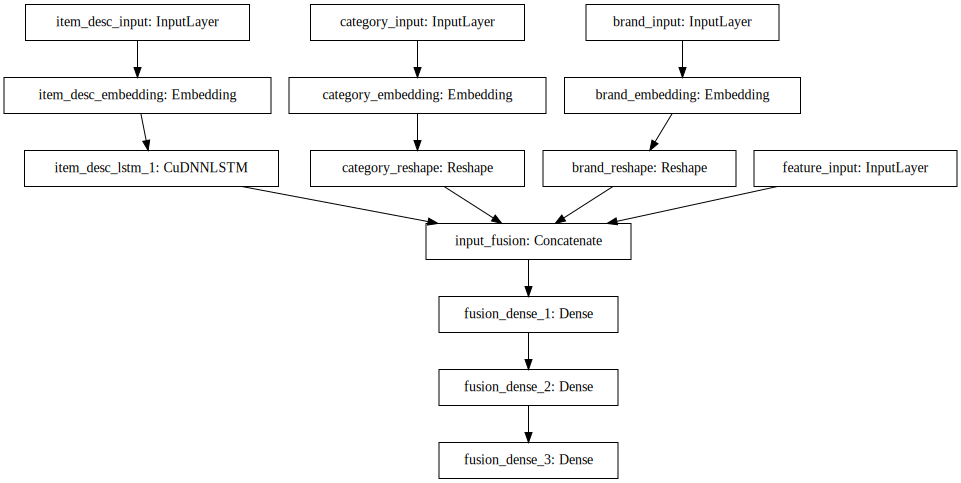

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc_input (InputLayer)    (None, 301)          0                                            
__________________________________________________________________________________________________
category_input (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
brand_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc_embedding (Embedding) (None, 301, 32)      640128      item_desc_input[0][0]            
__________________________________________________________________________________________________
category_e

In [10]:
from keras import backend as K

def root_mean_squared_logarithmic_error(y_true, y_pred):
    ret = losses.mean_squared_logarithmic_error(y_true, y_pred)
    return K.sqrt(ret)

def root_mean_squared_error(y_true, y_pred):
    ret = losses.mean_squared_error(y_true, y_pred)
    return K.sqrt(ret)


model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=[root_mean_squared_logarithmic_error])

history_simple = model.fit(
    [x_f_train, x_cat_train, x_brand_train, X_seq_train], y_train,
    batch_size=batch_size,
    epochs=10,
    shuffle=True)#,
    #validation_data=[x_test_pad, y_test])

Epoch 1/10
148253/148253 [==============================] - 90s 607us/step - loss: 13.9420 - root_mean_squared_logarithmic_error: 0.4962
Epoch 2/10
148253/148253 [==============================] - 89s 600us/step - loss: 12.8050 - root_mean_squared_logarithmic_error: 0.4388
Epoch 3/10
 34800/148253 [======>.......................] - ETA: 1:08 - loss: 12.6321 - root_mean_squared_logarithmic_error: 0.4307

KeyboardInterrupt: 